# Golbals

In [1]:
from ase import io
from pyobjcryst.crystal import Crystal
from diffpy.srfit.pdf import PDFGenerator
from pyobjcryst import loadCrystal
import numpy as np
import pandas as pd
import xarray as xr
from tqdm import tqdm
import multiprocessing as mp
import os
import json
import yaml
import fnmatch
import glob

In [2]:
import matplotlib.pyplot as plt
from bg_mpl_stylesheet.bg_mpl_stylesheet import bg_mpl_style
plt.style.use(bg_mpl_style)

In [28]:
%matplotlib qt

In [4]:
%matplotlib inline

# general functions

In [5]:
def ind2str(ind: int or str, num_of_dig):
    ind = str(ind)
    while True:
        if len(str(ind))<num_of_dig:
            ind = "0" + ind
        else:
            return ind

def str2ind(ind:str):
    return int(ind) 
    
    
def dump_cif(fn, img):
    assert fn.endswith('.cif')
    io.write(fn, img)
    
def read_traj(fn):
    return io.Trajectory(filename,'r')

def append_images(images, traj, equilibration_steps):
    for i in range(equilibration_steps, len(traj)):
        images.append(traj[i])
        
def update_pos_per_frame(images, pos):
    for i, img in enumerate(images):
        pos[i] = img.get_positions()   
        
def dump_frames(images, dump_dir_path, equilibration_steps):
    assert len(images) > equilibration_steps 
    try:  # to make a dir if does not exists
        os.makedirs(dump_dir_path, exist_ok=True)
        print(f'creating "{dump_dir_path}"')
    except:
        print(f'"{dump_dir_path}" folder exists. Skipping step.')
    for i in range(len(images)): 
        _imax = len(images)
        print(f"Dumping images: {i}/{_imax}", end="\r")
        img = images[i]
        global_step_num = i + equilibration_steps
        indstr = ind2str(global_step_num, len(str(len(images))))
        fn = indstr + '.cif'
        fp = os.path.join(dump_dir_path, fn)
        dump_cif(fp, img)

# extractor functions

In [6]:
def analyze_traj(filename, equilibration_steps = 10):
    # about 10-20 equilibration steps should be ignored since the MD simulation 
    # starts from the equilibrium structure
    
    # read traj
    traj = read_traj(filename)
    atoms_equ = traj[0].copy()
    # get frames obj
    images = []
    append_images(images, traj, equilibration_steps)

    nimages = len(images)
    natoms  = len(images[0])
    print('Natoms:',natoms)
    pos = np.zeros(( nimages, natoms, 3 ) )
    print('Images Averaged:', nimages)

    # fill pos's 
    update_pos_per_frame(images, pos)
    
    ##########
    pos_mean  = np.mean(pos,axis=0)
    pos_stdev = np.std(pos, axis=0)
    pos_stderr = pos_stdev/np.sqrt(nimages)
    print('\nSingle Coordinate Stats :')
    print('Max  stdev:', pos_stdev.max())
    print('Max stderr:', pos_stderr.max())
    
    
    ##### This tests the cooridate vibration anisotropy, a proper test in the furture will use the eigenvalues of the (inverse?) covariance matrix.
    max_coordinate_stdev = pos_stdev.max(axis=1)
    min_coordinate_stdev = pos_stdev.min(axis=1)
    
    vibration_anisotropy = max_coordinate_stdev/min_coordinate_stdev    
    most_anisotropic_index = np.argsort(vibration_anisotropy)[-1]
    
    print('Most anisotropic atom: %i (%s)'%( most_anisotropic_index, images[0][most_anisotropic_index].symbol ))
    print('Max vibration anisotropy:', vibration_anisotropy.max())

    ############ not sure if this is the correct way, but it's probably a good metric 
    r_stdev  = np.sqrt( (pos_stdev**2).sum(axis=1))
    r_stderr = r_stdev/np.sqrt(nimages)

    most_wiggly_index = np.argsort(r_stdev)[-1]

    print('\nCombined Coordinate Stats (dx**2+dy**2+dz**2)**1/2 :')
    print('Most active atom: %i (%s)'%( most_wiggly_index, images[0][most_wiggly_index].symbol ))
    print('Max  stdev:', r_stdev.max())
    print('Max stderr:', r_stderr.max())


    atoms_mean = atoms_equ.copy()
    atoms_mean.set_positions(pos_mean)

    return atoms_equ, atoms_mean, pos_stdev, images
    

# simulator functions 

In [7]:
class Simulator:
    def __init__(self):
        self.scale = 0.1
        self.qdamp = 0.032
        self.qbroad = 0.001
        self.delta1 = 0
        self.delta2 = 3.7
        self.Uiso = 0.000003
        self.Biso = 8*np.pi**2*self.Uiso
        self.qmin = 0
        self.qmax = 32
        self.rmin = 0
        self.rmax = 40
        self.rstep = 0.05

        self.xvector = np.arange(self.rmin, self.rmax, self.rstep)

        self.simsetup = dict(
            qdump=self.qdamp,
            qbroad=self.qbroad,
            delta1=self.delta1,
            delta2=self.delta2,
            Uiso=self.Uiso,
            Biso=self.Biso, 
            qmin=self.qmin,
            qmax=self.qmax,
            rmin=self.rmin,
            rmax=self.rmax,
            rstep=self.rstep,
            )
    
    def load_structure(self, path):
        """ loads structure """
        return loadCrystal(path)
    
    def _set_uiso(self, gen):
        atoms = gen.phase.getScatterers()
        for atom in atoms:
            atom.Biso.setValue(self.Biso)
    
    def set_gen_config(self, gen: PDFGenerator):
        """ sets the generator's configs"""
        gen.qdamp = self.qdamp
        gen.qbroad = self.qbroad
        gen.delta1=self.delta1
        gen.delta2=self.delta2
        gen.scale.value=self.scale
#         gen.setScale(self.scale)
        gen.setQmax(self.qmax)
        gen.setQmin(self.qmin)
        self._set_uiso(gen)
        
    def set_generator(self, genname: str, stru: Crystal):
        """
        sets up a generator
        Parameters
        ----------
        genname: str
            the name of the generator
        stru: Crystal
            the structure object

        Returns
        -------
        PDFgenerator with the name 'gname', having the structure 'stru'
        """
        gen = PDFGenerator(genname)
        gen.setStructure(stru)
        self.set_gen_config(gen)
        return gen
    
#     def set_generator(self, genname: str, stru: Crystal):
#         #  Songsheng's 
#         mpm = MultiPhaseModel("Ni", structures={"Ni": Ni})
#         mpm.set_value(Ni_Ni0_Biso=0.02)
#         r = np.arange(0, 30.0001, 0.01)
#         g = mpm.calc_phase("Ni", r)

def simulate_pdf(cif, compound_name, simulator, get_x=False):
    sim = simulator
    _id = os.path.basename(cif)
    stru = sim.load_structure(cif)
    gen = sim.set_generator(compound_name, stru)
    x = sim.xvector
    pdf = gen(x)    
    if get_x:
        return _id, pdf, x
    else:
        return _id, pdf

def _simulate_pdf_star(args):
    return simulate_pdf(*args)

## SET PATH

In [8]:
COMPOUND="NbTiZr"
main_path = '/home/yr2369/dat/data/MURI/PDF_FITTINGS/NTZ_calc/Mikes relaxed'

# data_of_interest = 'first_attempt'
data_of_interest = 'T_dep_relaxed_traj_20220206'


traj_DIRPATH = os.path.join(main_path, data_of_interest)
os.chdir(traj_DIRPATH)
# set traj file
filenames = [
    'mc_08_size_0.000000_Ofract_0.3333_Nb_0.3333_Ti_0.3333_Zr_0700_T_C.dc.md.traj',
    'mc_08_size_0.000000_Ofract_0.3333_Nb_0.3333_Ti_0.3333_Zr_0900_T_C.dc.md.traj',
    'mc_08_size_0.000000_Ofract_0.3333_Nb_0.3333_Ti_0.3333_Zr_1050_T_C.dc.md.traj',
    'mc_08_size_0.000000_Ofract_0.3333_Nb_0.3333_Ti_0.3333_Zr_1250_T_C.dc.md.traj'
]
filename = filenames[0]

In [9]:
# extract info from traj
equilibration_steps = 50 
atoms_equ, atoms_mean, coordinate_stdev, images = analyze_traj(filename, equilibration_steps)

Natoms: 1031
Images Averaged: 975

Single Coordinate Stats :
Max  stdev: 0.3145792698612127
Max stderr: 0.010074599541645657
Most anisotropic atom: 184 (Ti)
Max vibration anisotropy: 3.2844244658258916

Combined Coordinate Stats (dx**2+dy**2+dz**2)**1/2 :
Most active atom: 515 (Ti)
Max  stdev: 0.4089675003654353
Max stderr: 0.01309744215995969


In [10]:
# dump each frame
cif_DIRPATH = "frame_cifs"
if False:
    dump_frames(images, cif_DIRPATH, equilibration_steps)

In [11]:
# get equilibrium position
# mean positions - if harmonic, should be the same
if False:
    path = "equ_cif.cif"
    atoms_equ.write(path, format='cif')

# simulate PDFs

In [12]:
# collect cif files
files = map(os.path.abspath, list(os.path.join(cif_DIRPATH,f) for f in os.listdir(cif_DIRPATH)))
cifs = sorted(list(os.path.abspath(f) for f in files if f.endswith('.cif')))
print('num of files:', len(cifs))

FileNotFoundError: [Errno 2] No such file or directory: 'frame_cifs'

## == test ==

In [13]:
sim = Simulator()
_id, pdf, x = simulate_pdf(cifs[0], COMPOUND, sim, get_x = True)

NameError: name 'cifs' is not defined

NameError: name 'x' is not defined

<Figure size 432x288 with 0 Axes>

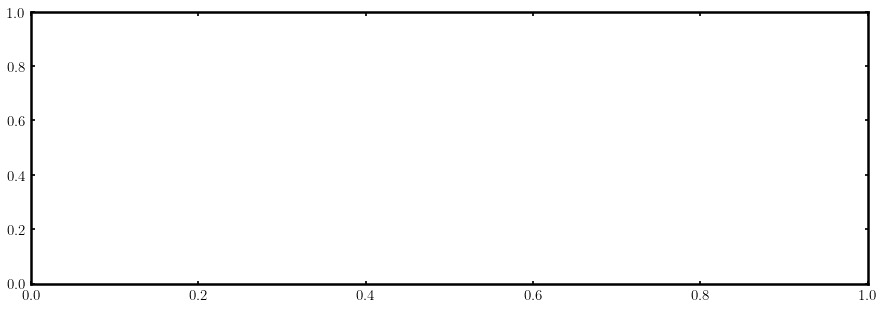

In [14]:
plt.clf()
fig, ax = plt.subplots(1,1, num ='== test ==', figsize = (15,5))
ax.plot(x,pdf)
ax.set_xlabel('$\mathrm{r~[\AA]}$')
ax.set_ylabel('$\mathrm{G~[\AA^{-2}]}$')
ax.set_title(_id)
plt.margins(0,(max(pdf)+abs(min(pdf)))*0.01)

In [28]:
# run all
if False:
    cif_dict = dict()
    sim = Simulator()
    for _id, cif in tqdm(enumerate(cifs), desc="simulate pdfs ", leave=True):
        stru = sim.load_structure(cif)
        gen = sim.set_generator(COMPOUND, stru)
        pdf = gen(sim.xvector)    
        cif_dict.update({_id:pdf})

In [29]:
# run all - parallel
if False:
    sim = Simulator()
    jobs = mp.cpu_count()  # 8
    with mp.Pool(jobs) as p:
        args = [(cif, COMPOUND, sim) for cif in cifs]
        cif_dict = list(tqdm(p.imap(_simulate_pdf_star, args), 
                                desc="simulate pdfs ",
                                total=len(cifs)
                            )
                       )
    cif_dict = dict(cif_dict)
    print(1)

In [30]:
# serialize df
if False:
    df = pd.DataFrame(data=cif_dict, index=sim.xvector)
    df.index.name = 'r'
    path = f"{COMPOUND}_sim_pdf.gr.csv"
    df.to_csv(path)

In [15]:
# master: All filenames
if True:
    for filename in filenames:
        # index name
        name = filename.replace(".dc.md.traj","")
        print("Name:", name)
        # extract info from traj
        equilibration_steps = 50 
        atoms_equ, atoms_mean, coordinate_stdev, images = analyze_traj(filename, equilibration_steps)
        
        # dump each frame
        cif_DIRPATH = f"frame_cifs___{name}"
        dump_frames(images, cif_DIRPATH, equilibration_steps)
        
        # collect cif files
        files = map(os.path.abspath, list(os.path.join(cif_DIRPATH,f) for f in os.listdir(cif_DIRPATH)))
        cifs = sorted(list(os.path.abspath(f) for f in files if f.endswith('.cif')))
        print(f'num of frames in "{cif_DIRPATH}"\n {len(cifs)}')
        
        # run all - parallel
        sim = Simulator()
        jobs = 6 # mp.cpu_count()  # 8
        with mp.Pool(jobs) as p:
            args = [(cif, COMPOUND, sim) for cif in cifs]
            cif_dict = list(tqdm(p.imap(_simulate_pdf_star, args), 
                                    desc="simulate pdfs ", leave=True,
                                    total=len(cifs)
                                )
                           )
        cif_dict = dict(cif_dict)
        
        # dump values
        df = pd.DataFrame(data=cif_dict, index=sim.xvector)
        df.index.name = 'r'
        path = f"{name}_sim_pdf.gr.csv"
        df.to_csv(path)
        
        # dump mean
        df_mean = df.mean(axis=1)
        path = f"{name}_sim_pdf_MEAN.gr"
        arr = np.stack([df_mean.index.values, df_mean.values])
        header = COMPOUND + "\n" + yaml.dump(sim.simsetup, indent =2, sort_keys=False)
        np.savetxt(path, arr.T, header=header, comments="# ")

Name: mc_08_size_0.000000_Ofract_0.3333_Nb_0.3333_Ti_0.3333_Zr_0700_T_C
Natoms: 1031
Images Averaged: 975

Single Coordinate Stats :
Max  stdev: 0.3145792698612127
Max stderr: 0.010074599541645657
Most anisotropic atom: 184 (Ti)
Max vibration anisotropy: 3.2844244658258916

Combined Coordinate Stats (dx**2+dy**2+dz**2)**1/2 :
Most active atom: 515 (Ti)
Max  stdev: 0.4089675003654353
Max stderr: 0.01309744215995969
creating "frame_cifs___mc_08_size_0.000000_Ofract_0.3333_Nb_0.3333_Ti_0.3333_Zr_0700_T_C"
num of frames in "frame_cifs___mc_08_size_0.000000_Ofract_0.3333_Nb_0.3333_Ti_0.3333_Zr_0700_T_C"
 975


simulate pdfs : 100%|█████████████████████████| 975/975 [41:35<00:00,  2.56s/it]


Name: mc_08_size_0.000000_Ofract_0.3333_Nb_0.3333_Ti_0.3333_Zr_0900_T_C
Natoms: 1030
Images Averaged: 975

Single Coordinate Stats :
Max  stdev: 0.293161993146288
Max stderr: 0.009388697745666941
Most anisotropic atom: 467 (Nb)
Max vibration anisotropy: 3.182882107972368

Combined Coordinate Stats (dx**2+dy**2+dz**2)**1/2 :
Most active atom: 958 (Nb)
Max  stdev: 0.4190395400295978
Max stderr: 0.013420005583254482
creating "frame_cifs___mc_08_size_0.000000_Ofract_0.3333_Nb_0.3333_Ti_0.3333_Zr_0900_T_C"
num of frames in "frame_cifs___mc_08_size_0.000000_Ofract_0.3333_Nb_0.3333_Ti_0.3333_Zr_0900_T_C"
 975


simulate pdfs : 100%|█████████████████████████| 975/975 [41:32<00:00,  2.56s/it]


Name: mc_08_size_0.000000_Ofract_0.3333_Nb_0.3333_Ti_0.3333_Zr_1050_T_C
Natoms: 1030
Images Averaged: 975

Single Coordinate Stats :
Max  stdev: 0.29509308633868525
Max stderr: 0.00945054222321177
Most anisotropic atom: 655 (Zr)
Max vibration anisotropy: 3.311396797165943

Combined Coordinate Stats (dx**2+dy**2+dz**2)**1/2 :
Most active atom: 655 (Zr)
Max  stdev: 0.34077590933804924
Max stderr: 0.010913563444710317
creating "frame_cifs___mc_08_size_0.000000_Ofract_0.3333_Nb_0.3333_Ti_0.3333_Zr_1050_T_C"
num of frames in "frame_cifs___mc_08_size_0.000000_Ofract_0.3333_Nb_0.3333_Ti_0.3333_Zr_1050_T_C"
 975


simulate pdfs : 100%|█████████████████████████| 975/975 [41:39<00:00,  2.56s/it]


Name: mc_08_size_0.000000_Ofract_0.3333_Nb_0.3333_Ti_0.3333_Zr_1250_T_C
Natoms: 1029
Images Averaged: 975

Single Coordinate Stats :
Max  stdev: 0.2837032077729633
Max stderr: 0.009085774177853133
Most anisotropic atom: 679 (Ti)
Max vibration anisotropy: 3.5274217158549566

Combined Coordinate Stats (dx**2+dy**2+dz**2)**1/2 :
Most active atom: 614 (Ti)
Max  stdev: 0.34929543543559866
Max stderr: 0.011186406641769285
creating "frame_cifs___mc_08_size_0.000000_Ofract_0.3333_Nb_0.3333_Ti_0.3333_Zr_1250_T_C"
num of frames in "frame_cifs___mc_08_size_0.000000_Ofract_0.3333_Nb_0.3333_Ti_0.3333_Zr_1250_T_C"
 975


simulate pdfs : 100%|█████████████████████████| 975/975 [41:43<00:00,  2.57s/it]


# analyze PDFs

In [20]:
# load dfs  XXX
dirpath = 'T_dep_relaxed_traj_20220206'
files = fnmatch.filter(os.listdir(path), "*.py")
dfs_d = dict((fn,None) )
for df_d in dfs_d:
if False:
    path = f"{COMPOUND}_sim_pdf.gr.csv"
    df = pd.read_csv(path, index_col=0)
# df

IndentationError: expected an indented block (2667573126.py, line 6)

In [21]:
def sorting_filter(string):
    return float(string.rsplit("_T_",1)[0].rsplit('_',1)[0])
sorting_filter

<function __main__.sorting_filter(string)>

In [23]:
pwd

'/home/yr2369/dat/data/MURI/PDF_FITTINGS/NTZ_calc/Mikes relaxed/T_dep_relaxed_traj_20220206'

In [29]:
dirpath = './'
def temp_extractor_filter(string):
    return_ = string.rsplit("_T_",1)[0].rsplit('_',1)[-1]
#     print(return_)
    return int(return_)
filter_key = temp_extractor_filter

csv_files = sorted(list(os.path.join(dirpath,fn) for fn in fnmatch.filter(os.listdir(dirpath), "*.gr.csv")),
                   key=filter_key)
mean_gr_files = sorted(list(os.path.join(dirpath,fn) for fn in fnmatch.filter(os.listdir(dirpath), "*MEAN.gr")),
                       key=filter_key)
print(yaml.dump(csv_files))
print(yaml.dump(mean_gr_files))

- ./mc_08_size_0.000000_Ofract_0.3333_Nb_0.3333_Ti_0.3333_Zr_0700_T_C_sim_pdf.gr.csv
- ./mc_08_size_0.000000_Ofract_0.3333_Nb_0.3333_Ti_0.3333_Zr_0900_T_C_sim_pdf.gr.csv
- ./mc_08_size_0.000000_Ofract_0.3333_Nb_0.3333_Ti_0.3333_Zr_1050_T_C_sim_pdf.gr.csv
- ./mc_08_size_0.000000_Ofract_0.3333_Nb_0.3333_Ti_0.3333_Zr_1250_T_C_sim_pdf.gr.csv

- ./mc_08_size_0.000000_Ofract_0.3333_Nb_0.3333_Ti_0.3333_Zr_0700_T_C_sim_pdf_MEAN.gr
- ./mc_08_size_0.000000_Ofract_0.3333_Nb_0.3333_Ti_0.3333_Zr_0900_T_C_sim_pdf_MEAN.gr
- ./mc_08_size_0.000000_Ofract_0.3333_Nb_0.3333_Ti_0.3333_Zr_1050_T_C_sim_pdf_MEAN.gr
- ./mc_08_size_0.000000_Ofract_0.3333_Nb_0.3333_Ti_0.3333_Zr_1250_T_C_sim_pdf_MEAN.gr



In [25]:
# collect data
collection = dict()
for csv_fn, mean_gr_fn in zip(csv_files, mean_gr_files):
    df = pd.read_csv(csv_fn, index_col=0)
    mean_gr = np.loadtxt(mean_gr_fn)
    collection.update(
        {
            str(temp_extractor_filter(csv_fn)):
            {
                "all":df,
                "mean":mean_gr.T
            }
        }
    )
collection['700']['mean']

array([[ 0.00000000e+00,  5.00000000e-02,  1.00000000e-01, ...,
         3.98500000e+01,  3.99000000e+01,  3.99500000e+01],
       [ 0.00000000e+00, -2.96738961e-03, -6.46594033e-03, ...,
        -1.17679414e-01, -1.15395370e-01, -1.10006693e-01]])

In [31]:
# plot data
fig_numb = len(collection)
fig, axs = plt.subplots(ncols=1, 
                        nrows=fig_numb, 
                        num='results', 
                        figsize=(15,5*fig_numb), 
                        sharex=True)
axs = list(axs)

for i, (_id, data) in enumerate(collection.items()):
    axs[i].plot(data['all'], '.', lw = 0)
    axs[i].plot(data['mean'][0], data['mean'][1])
    axs[i].set_title(f"{_id} C")
    axs[i].set_ylabel('$\mathrm{G~[\AA^{-2}]}$')

axs[i].set_xlabel('$\mathrm{r~[\AA]}$')
fig.savefig(os.path.join(dirpath,'results'), dpi= 150)

In [32]:
# plot - compare means
fig, ax = plt.subplots(ncols=1, 
                        nrows=1, 
                        num='means', 
                        figsize=(15,5), 
                        sharex=True)
for i, (_id, data) in enumerate(collection.items()):
    ax.plot(data['mean'][0], data['mean'][1], label = f"{_id} C")
ax.set_ylabel('$\mathrm{G~[\AA^{-2}]}$')
ax.set_xlabel('$\mathrm{r~[\AA]}$')
ax.set_title(f"comparing mean PDFs")
ax.legend()
fig.savefig(os.path.join(dirpath,'comparing means'), dpi= 150)

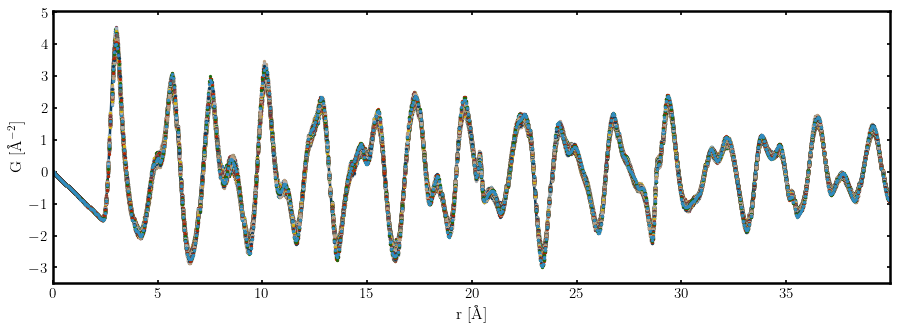

In [54]:
# get mean
df_mean = df.mean(axis=1)
fig, ax = plt.subplots(1,1,num='mean', figsize=(15,5))
plt.plot(df_mean)
plt.plot(df, '.', lw = 0)
ax.set_xlabel('$\mathrm{r~[\AA]}$')
ax.set_ylabel('$\mathrm{G~[\AA^{-2}]}$')
plt.margins(0,(max(pdf)+abs(min(pdf)))*0.01)
path = f"{COMPOUND}_sim_pdf_MEAN.gr"
arr = np.stack([df_mean.index.values, df_mean.values])
header = COMPOUND + "\n" + yaml.dump(sim.simsetup, indent =2, sort_keys=False)
np.savetxt(path, arr.T, header=header, comments="# ")

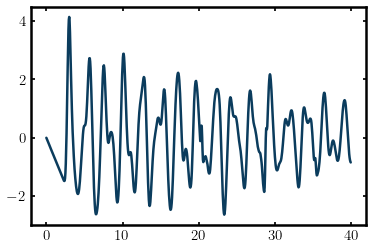

In [55]:
plt.plot(df_mean)
